In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
from scipy.integrate import simps

In [51]:
###################################################################################
#########                                                   #######################
#########     For set of data with same cycling setting     #######################
#########                                                   #######################
###################################################################################

# number of data files for a set
n_datafile = 5

# array of electrode mass for each data set, in (mg)
         #1     #2     #3     #4     #5    #6 etc
e_mass = [0.67, 0.68 , 0.664, 0.856, 0.584]

# directory path to raw data 
data_path = r"C:\Users\Yuyoung_Shin\Desktop\python_ex\jameela\data_3"

# name of directory to save plot.jpg files
plot_directory = 'plots'

# name of directory to save analysis files
analysis_directory = 'analysis'

# name of directory to save data files divided into cycles
cycledata = 'cycle_data'

# name of one example log file for details of cycling setting  
logfile = "log_data.txt"

# Select which cycles for each scan rate to be used for plotting and analysis for each data file
selected_cycles = np.array([2,5,8,11,14]) # default example here is cycle 2, 5, 8 ,11, middle of 3 cycles for each scan rates
cn_1, cn_2, cn_3, cn_4, cn_5= selected_cycles


In [52]:
os.chdir(data_path)

######################    Reading in the log data to collect cycling details    ###############
datalog = pd.read_csv(logfile, skiprows = 27, sep = '          ')
datalog.drop([2,3,8,10,11,12,13,14,15,16,17,18,21,22,24,25,26,27,28,29], 0, inplace=True)

########## assuming same repeated cycle for each scan rate   ##################
repeat_rate_cycle = int(datalog.iat[9,1])+1
row_log, col_log =datalog.shape
n_scan = col_log-1
total_n_cycle = n_scan * repeat_rate_cycle

# n_scan = number of different scan rates
# total_n_cycle = total number of cycles
# repeat_rate_cycle = number of repeated cycles for each scan rate
#assuming same number of sub-cycles(nc cycles) for each scan rate sets

################  assuming same max_voltage for every scan rate  #################
max_voltage = datalog.iat[7,1].strip()
max_voltage = float(max_voltage.replace(',','.'))

##############    making a list of scan rates     ##########################
scan_rate = []
scan_rate_unit = datalog.iat[3,1]

for i in range(1,n_scan+1):
    rate = datalog.iat[2,i].strip() 
    rate = float(rate.replace(',','.'))
    scan_rate.append(rate)
    
print ('total cycle number is ', total_n_cycle)
print ('max voltage for each cycle is ', max_voltage)
print ('For each scan rate, repated cycle number is ', repeat_rate_cycle)
print ('list of scan rate is ', scan_rate)
print ('unit of scan rate is ', scan_rate_unit)

scan_rate_arr = np.array(scan_rate)
sr_1, sr_2, sr_3, sr_4, sr_5 = scan_rate_arr

os.mkdir(plot_directory)
os.mkdir(analysis_directory)
os.mkdir(cycledata)

total cycle number is  15
max voltage for each cycle is  4.0
For each scan rate, repated cycle number is  3
list of scan rate is  [0.1, 0.5, 1.0, 5.0, 10.0]
unit of scan rate is  mV/s


C:\Users\Yuyoung_Shin\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/929962927.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  datalog.drop([2,3,8,10,11,12,13,14,15,16,17,18,21,22,24,25,26,27,28,29], 0, inplace=True)


In [53]:
os.chdir(data_path)

In [54]:
for n_data in range (1, n_datafile+1):
    filename = str(n_data)+'.csv'
    filename_npy = str(n_data)+'.npy'
    #######################      Reading in the data and cleanup into dataframe   ######################
    data = pd.read_csv(filename, skiprows = 1, delimiter="\t")
    data = data[["Ewe/V", "<I>/µA"]]
    data = data.applymap(lambda x: str(x.replace(',','.')))
    data_array = data.to_numpy()
    data_array = data_array.astype(np.float)
    data_array[:,1]*=0.001
    electrode_mass = e_mass[n_data - 1]
    e_1 = 1/electrode_mass
    data_array[:,1]*=e_1
         
    ###################################################################################
    #########                                                   #######################
    #########     Dividing each data file into each cycles      #######################
    #########                                                   #######################
    ###################################################################################
    ######################### setting variables required for checking cycles in the dataset ####################
    nrows, ncols= data_array.shape
    array_cycle=[]
    array_cycle2=[]
    ############################################################################################################
    for rows in range(100,nrows):
        if float(data_array[rows,0]) > max_voltage-0.002:
            array_cycle.append(rows)
    size = np.size(array_cycle)
    for i in range(0,size):
        if i < size-1:
            if int(array_cycle[i])+1 == int(array_cycle[i+1]):
                pass
            else:
                array_cycle2.append(array_cycle[i])
        else:
            array_cycle2.append(array_cycle[i])
        
    ################## to check whether number of picked rows are correct##############
    print('for data file ',str(n_data), ':')
    if total_n_cycle == np.size(array_cycle2):
        print ('correct number of cycles picked.', 'Total cycle is ', total_n_cycle,)
    else:
        print('Total cycle is ', total_n_cycle, ',but number of picked out cycle is ', np.size(array_cycle2))

    ##########    Dividing the whole data into set of arrays for each cycle    ##################
    data_divided = {}
    ###  data_divided dictionary hold each cycle date with cycle number as index  ###
    
    size2= np.size(array_cycle2)
    for i in range (0,size2):
        cycle_number = i+1
        if i == 0:
            array_temp = data_array[0:int(array_cycle2[i])]
        else:
            array_temp = data_array[int(array_cycle2[i-1]):int(array_cycle2[i])]
        data_divided[cycle_number] = array_temp 
        
    os.chdir(analysis_directory)
    np.save(filename_npy, data_divided)
    ###################################################################################
    #########                                                   #######################
    #########        calculating capacity for each cycle        #######################
    #########                                                   #######################
    ###################################################################################
    ######    set range for maximum voltage from 0V ######################
    capacity_arr = np.empty([total_n_cycle, 3])
    #####################################################################
    
    for cycle_number in range(1,total_n_cycle+1):
        array = data_divided[cycle_number]
        array = array.astype(np.float)
        #array[:,1]*=0.001
        array = array[200:, :]
    
        positive=np.where(array[:,1]>=0)
        array_pos= array[positive]
        Ews = array_pos[:,0]
        I = array_pos[:,1]
        peak_current = max(I)

        area = simps(I,Ews)
        capacity_arr[cycle_number-1,0]= cycle_number
        capacity_arr[cycle_number-1,1]= area
        capacity_arr[cycle_number-1,2]= peak_current

    df_capacity = pd.DataFrame(capacity_arr, columns = ['cycle number','total area_A.V/g','peak current'])
    capacity_filename = 'capacity_data_'+str(n_data)+'.csv'
    df_capacity.to_csv(capacity_filename)
    
    a= selected_cycles-[1,1,1,1,1]
    selected_capacity=capacity_arr[a, :]
    #insert scan rate column before column in index position 1
    selected_capacity = np.insert(selected_capacity, 1, scan_rate_arr, axis=1)
    cap_total= selected_capacity[:,2]/selected_capacity[:,1]/3.6
    log_scan = np.log10(selected_capacity[:,1])
    log_peak = np.log10(selected_capacity[:,3])

    selected_capacity = np.delete(selected_capacity, [2], axis=1)
    selected_capacity = np.insert(selected_capacity, 2, cap_total, axis=1)
    selected_capacity = np.insert(selected_capacity, 3, log_scan, axis=1)
    selected_capacity = np.insert(selected_capacity, 4, log_peak, axis=1)
    
    df_capacity_2 = pd.DataFrame(selected_capacity, columns = ['cycle number','scan rate (mV/s)','specific capacity (A.h/g)','log(scan rate)', 'log(peak current)', 'Peak Current(mA)'])
    capacity_filename_2 = 'capacity_selected_'+str(n_data)+'.csv'
    df_capacity_2.to_csv(capacity_filename_2)
 
    os.chdir('..')
    # in directory data



C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/1397921598.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_array = data_array.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/1397921598.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  array = array.astype(np.float)
C:\Users\Yuyoung_Shin\anaconda3\lib\s

for data file  1 :
correct number of cycles picked. Total cycle is  15
for data file  2 :
correct number of cycles picked. Total cycle is  15
for data file  3 :
correct number of cycles picked. Total cycle is  15
for data file  4 :
correct number of cycles picked. Total cycle is  15
for data file  5 :
correct number of cycles picked. Total cycle is  15


C:\Users\Yuyoung_Shin\anaconda3\lib\site-packages\scipy\integrate\_quadrature.py:415: RuntimeWarning: divide by zero encountered in true_divide
  tmp = hsum/6.0 * (y[slice0] * (2 - 1.0/h0divh1) +


In [55]:
os.chdir(data_path)

In [56]:
###################################################################################
#########                                                   #######################
#########     saving cycle-divided data into csv files      #######################
#########                                                   #######################
###################################################################################
    
    
for n_data in range (1, n_datafile+1):
    filename_npy = str(n_data)+'.npy'
    
    os.chdir(analysis_directory)
    new_dict = np.load(filename_npy, allow_pickle='TRUE')
    new_dict= new_dict.item()
    a = new_dict.keys()
    row_arr = []
    
    for i in a:
        cycle_data = new_dict[i]
        rows, cols = np.shape(cycle_data)
        row_arr.append(rows) 
    
    for i in a:
        cycle_data = new_dict[i]
        rows, cols = np.shape(cycle_data)
        if rows == min(row_arr):
            pass
        else:
            n_r_delete = rows - min(row_arr)
            cycle_data = np.delete(cycle_data, slice(0, n_r_delete), axis=0)
        if i == 1:
            cycle_arr = cycle_data
        else:
            cycle_arr = np.concatenate((cycle_arr,cycle_data), axis=1)
    
    df_cycle = pd.DataFrame(cycle_arr)
    
    os.chdir('..')
    os.chdir(cycledata)
    filename_csv = 'data_' +str(n_data)+'.csv'
    df_cycle.to_csv(filename_csv)    
    os.chdir('..')
    

In [57]:
os.chdir(data_path)

C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/2166572800.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ews_1 = Ews_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/2166572800.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_1 =I_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492

C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/2166572800.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ews_1 = Ews_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/2166572800.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_1 =I_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492

C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/2166572800.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ews_1 = Ews_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/2166572800.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_1 =I_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492

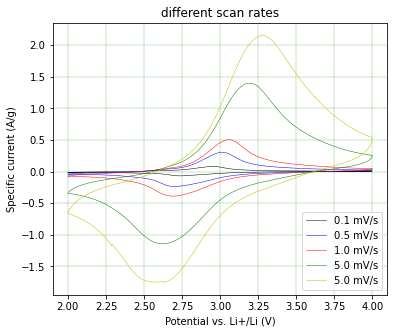

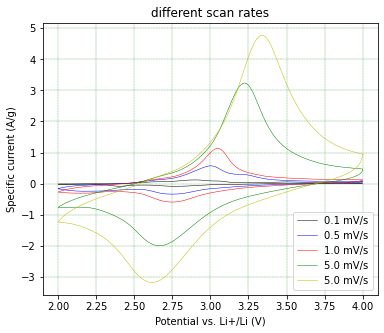

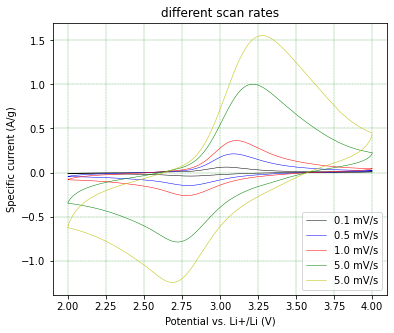

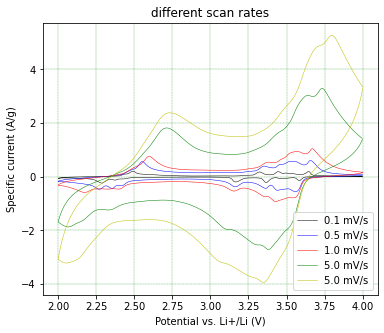

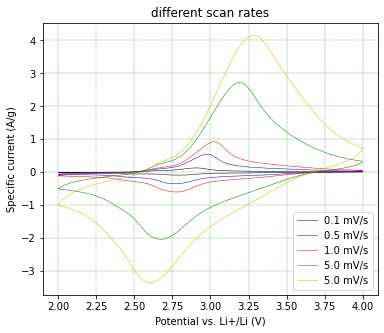

In [58]:
###################################################################################
#########                                                   #######################
#########   plotting different scanrates for each datafile  #######################
#########                                                   #######################
###################################################################################

# Select which cycles for each scan rate to be used for plotting and analysis for each data file
selected_cycles = np.array([2,5,8,11,14]) # default example here is cycle 2, 5, 8 ,11, middle of 3 cycles for each scan rates
cn_1, cn_2, cn_3, cn_4, cn_5= selected_cycles

######################################################################
    
for n_data in range (1, n_datafile+1):
    filename_npy = str(n_data)+'.npy'
    
    os.chdir(analysis_directory)
    new_dict = np.load(filename_npy, allow_pickle='TRUE')
    cycle_data = new_dict.item()
    
    #scan_rate_1
    array1 = cycle_data[cn_1]
    Ews_1 = array1[:,0]
    Ews_1 = Ews_1.astype(np.float)
    I_1 = array1[:,1]
    I_1 =I_1.astype(np.float)

    #scan_rate_2
    array2 = cycle_data[cn_2]
    Ews_2 = array2[:,0]
    Ews_2 = Ews_2.astype(np.float)
    I_2 = array2[:,1]
    I_2 =I_2.astype(np.float)

    #scan_rate_3
    array3 = cycle_data[cn_3]
    Ews_3 = array3[:,0]
    Ews_3 = Ews_3.astype(np.float)
    I_3 = array3[:,1]
    I_3 =I_3.astype(np.float)

    #scan_rate_4
    array4 = cycle_data[cn_4]
    Ews_4 = array4[:,0]
    Ews_4 = Ews_4.astype(np.float)
    I_4 = array4[:,1]
    I_4 =I_4.astype(np.float)
    
    #scan_rate_5
    array5 = cycle_data[cn_5]
    Ews_5 = array5[:,0]
    Ews_5 = Ews_5.astype(np.float)
    I_5 = array5[:,1]
    I_5 =I_5.astype(np.float)
    
    os.chdir('..')
    os.chdir(plot_directory)
    title = 'different scan rates_'+str(n_data)+'.jpg'
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(Ews_1, I_1, "k", linewidth = '0.5', label = str(sr_1)+' mV/s')
    ax.plot(Ews_2, I_2, "b", linewidth = '0.5', label = str(sr_2)+' mV/s')
    ax.plot(Ews_3, I_3, "r", linewidth = '0.5', label = str(sr_3)+' mV/s')
    ax.plot(Ews_4, I_4, "g", linewidth = '0.5', label = str(sr_4)+' mV/s')
    ax.plot(Ews_5, I_5, "y", linewidth = '0.5', label = str(sr_4)+' mV/s')
    ax.set_title('different scan rates')
    ax.set_xlabel('Potential vs. Li+/Li (V)')
    #plt.ylim([-700, 700])
    #plt.xlim([-0.1, 3.1]
    ax.set_ylabel('Specific current (A/g)', color ='k')
    ax.grid(color = 'green', linestyle = '--', linewidth = 0.3)
    leg = ax.legend(loc = "lower right")
    #plt.show()
    fig.savefig(title, dpi =150, bbox_inches='tight')
    os.chdir('..')
        
        
        

In [59]:
os.chdir(data_path)

C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/3397201390.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ews_1 = Ews_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/3397201390.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_1 =I_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492

C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/3397201390.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ews_1 = Ews_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/3397201390.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_1 =I_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492

C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/3397201390.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ews_1 = Ews_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492/3397201390.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_1 =I_1.astype(np.float)
C:\Users\YUYOUN~1\AppData\Local\Temp/ipykernel_3492

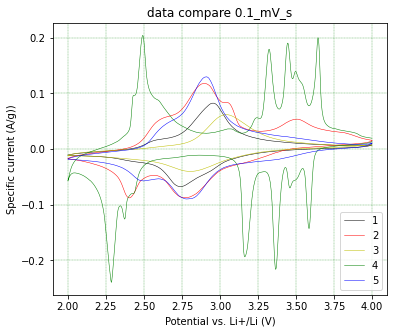

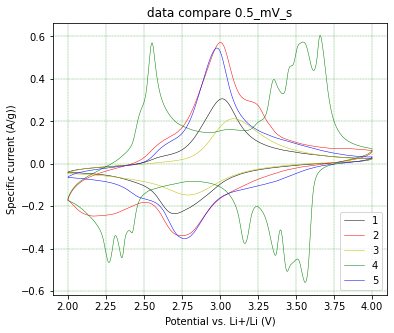

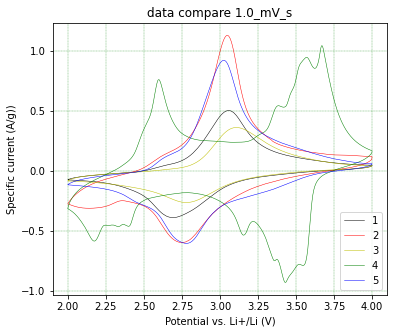

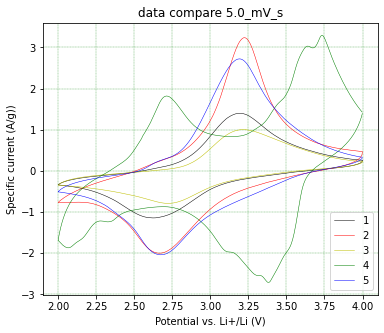

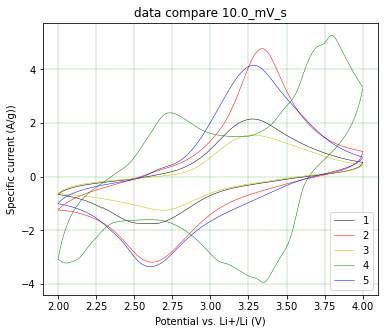

In [64]:
###################################################################################
#########                                                   #######################
#########     plotting selected data with same scan rates   #######################
#########                                                   #######################
###################################################################################

selected_files = np.array([1,2,3,4,5])  # select data file number for comparison plotting
sf_1, sf_2, sf_3, sf_4, sf_5 = selected_files
compare_dict ={}
plotname= 'test_'

for i in selected_files:
    filename_npy = str(i)+'.npy'
    os.chdir(analysis_directory)
    new_dict = np.load(filename_npy, allow_pickle='TRUE')
    new_dict = new_dict.item()

    v1 = new_dict[cn_1]
    v2 = new_dict[cn_2]
    v3 = new_dict[cn_3]
    v4 = new_dict[cn_4]
    v5 = new_dict[cn_5]
    
    k1 = str(i)+'v1'
    k2 = str(i)+'v2'
    k3 = str(i)+'v3'
    k4 = str(i)+'v4'
    k5 = str(i)+'v5'
    
    
    compare_dict[k1] = v1
    compare_dict[k2] = v2
    compare_dict[k3] = v3
    compare_dict[k4] = v4
    compare_dict[k5] = v5
    
    os.chdir('..')

for i, sr in enumerate(scan_rate_arr):
    k_1 = str(selected_files[0])+'v'+ str(i+1)
    k_2 = str(selected_files[1])+'v'+ str(i+1)
    k_3 = str(selected_files[2])+'v'+ str(i+1)
    k_4 = str(selected_files[3])+'v'+ str(i+1)
    k_5 = str(selected_files[4])+'v'+ str(i+1)
        
    #dat_1
    array1 = compare_dict[k_1]
    Ews_1 = array1[:,0]
    Ews_1 = Ews_1.astype(np.float)
    I_1 = array1[:,1]
    I_1 =I_1.astype(np.float)

    #data_2
    array2 = compare_dict[k_2]
    Ews_2 = array2[:,0]
    Ews_2 = Ews_2.astype(np.float)
    I_2 = array2[:,1]
    I_2 =I_2.astype(np.float)

    #data_3
    array3 = compare_dict[k_3]
    Ews_3 = array3[:,0]
    Ews_3 = Ews_3.astype(np.float)
    I_3 = array3[:,1]
    I_3 =I_3.astype(np.float)

    #data_4
    array4 = compare_dict[k_4]
    Ews_4 = array4[:,0]
    Ews_4 = Ews_4.astype(np.float)
    I_4 = array4[:,1]
    I_4 =I_4.astype(np.float)
    
    #data_5
    array5 = compare_dict[k_5]
    Ews_5 = array5[:,0]
    Ews_5 = Ews_5.astype(np.float)
    I_5 = array5[:,1]
    I_5 =I_5.astype(np.float)
    
    
    os.chdir(plot_directory)
    
    title = plotname+str(sr)+'_mV_s.jpg'
    
    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.plot(Ews_1, I_1, "k", linewidth = '0.5', label = str(sf_1))
    ax.plot(Ews_2, I_2, "r", linewidth = '0.5', label = str(sf_2))
    ax.plot(Ews_3, I_3, "y", linewidth = '0.5', label = str(sf_3))
    ax.plot(Ews_4, I_4, "g", linewidth = '0.5', label = str(sf_4))
    ax.plot(Ews_5, I_5, "b", linewidth = '0.5', label = str(sf_5))
    ax.set_title('data compare '+str(sr)+'_mV_s')
    ax.set_xlabel('Potential vs. Li+/Li (V)')
    ax.set_ylabel('Specific current (A/g))', color ='k')
    ax.grid(color = 'green', linestyle = '--', linewidth = 0.3)
    #plt.ylim([-700, 700])
    #plt.xlim([-0.05, 1.0])  
    leg = ax.legend(loc = "lower right")
    #plt.show()
    fig.savefig(title, dpi =150, bbox_inches='tight')
    os.chdir('..')
    
    

In [61]:
os.chdir(data_path)

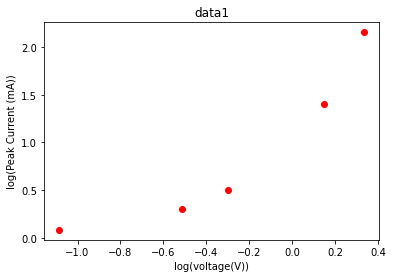

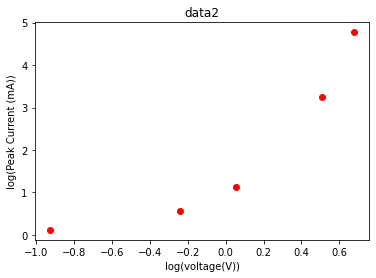

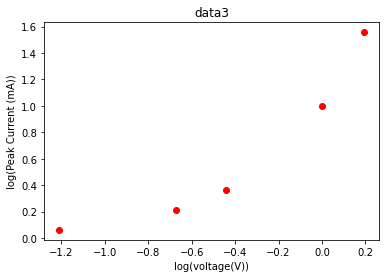

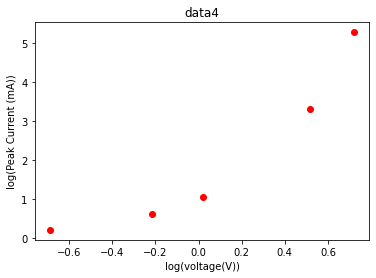

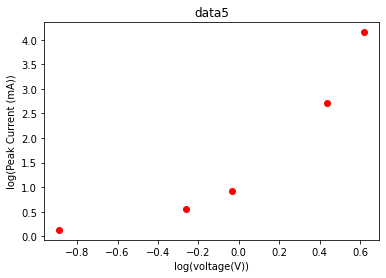

In [62]:
######################################################################################
#########                                                      #######################
#########     plotting log(i_p) vs. log(v) and b-value calc.   #######################
#########                                                      #######################
######################################################################################
from scipy.stats import linregress

b_arr = np.empty([n_datafile, 4])

for i in range (1, n_datafile+1):
    filename_csv = 'capacity_selected_'+ str(i)+'.csv'
    os.chdir(analysis_directory)
    arr = np.genfromtxt(filename_csv, delimiter=",")
    arr = np.delete(arr, [0], axis=0)
    arr = np.delete(arr, [0,1,3,4], axis=1)
    log_v = arr[:, 1]
    log_I_p = arr[:,2]
    
    fitting = linregress(log_v, log_I_p)
    
    slope = fitting.slope
    intercept = fitting.intercept
    r_value = fitting.rvalue

    b_arr[i-1,0] = i
    b_arr[i-1,1] = slope
    b_arr[i-1,2] = intercept
    b_arr[i-1,3] = r_value
    
    os.chdir('..')
    os.chdir(plot_directory)
    
    title = 'log(I_p)_vs_log(v)_data_'+str(i)+'.jpg' 
    plt.scatter(log_v, log_I_p, c="r")
    plt.title('data'+str(i))
    plt.xlabel('log(voltage(V))')
    plt.ylabel('log(Peak Current (mA))')
    
    plt.savefig(title, dpi=150, format="jpg")
    plt.show()

    os.chdir('..')
    
os.chdir(analysis_directory)
df_b = pd.DataFrame(b_arr, columns = ['cycle number','slope','intercept', 'r_value'])
df_b.to_csv('b_values.csv')    
os.chdir('..')